In [922]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d

In [923]:
def compute_offsets(ell,  varcl, clref, fsky=1.0, iter=10):
    Nl = np.sqrt(np.abs(varcl - (2.0 / (2.0 * ell + 1) * clref ** 2) / fsky))
    for i in range(iter):
        Nl = np.sqrt(np.abs(varcl - 2.0 / (2.0 * ell + 1) / fsky * (clref ** 2 + 2.0 * Nl * clref)))
    return Nl * np.sqrt((2.0 * ell + 1) / 2.0)

In [924]:
def g(x):
    #return np.sign(np.abs(x) - 1) * np.sqrt(2.0 * (np.abs(x) - np.log(np.abs(x)) - 1))
    return np.sign(x) * np.sign(np.abs(x) - 1) * np.sqrt(2.0 * (np.abs(x) - np.log(np.abs(x)) - 1))

In [950]:
lmin = 2
lmax = 29
ells = np.arange(lmin,lmax+1) #multipoli da 2 a 29

nsims = 500
nsimscov = 250
nval = nsims-nsimscov

#io ho meno simulazioni
ntaus=121
taus = np.arange(ntaus)/1000+0.01
prior = 0

ntausover = 12001
tausover = np.arange(ntausover)/100000+0.01
priorover = 0

fskys = [0.501,0.441,0.441,0.542]

offsets = []

In [951]:
#fidcl = np.loadtxt(
        #'/Users/valentinagenesini/Documents/thesis/tools/spettri_teorici/spettri_variazione_tau0050.dat',
        #unpack=True,
        #usecols=(2,)
        #)[lmin-2:lmax-1]

 
thcls = np.empty((ntaus,lmax-1-lmin+2))




In [952]:
for i in range (ntaus):
    a=hp.read_cl('/Users/valentinagenesini/Documents/thesis/tools/spettri_teorici/spettri_variazione_tau'+str(i).zfill(4)+'.dat')
    thcls[i]=a[1,(lmin-2):(lmax-1)]
    
fidcl=thcls[50,:]

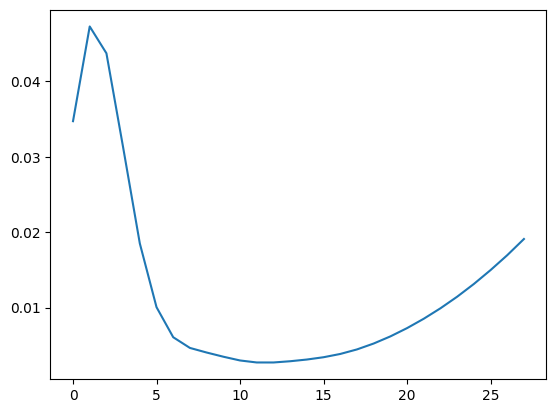

In [953]:
plt.plot(thcls[50,:])

In [954]:
#thcls = np.empty((ntaus,lmax-1-lmin+2))

#for itau in range(ntaus):
        #thcls[itau] = np.loadtxt(
        #'/Users/valentinagenesini/Documents/thesis/tools/spettri_teorici/spettri_variazione_tau'+str(i).zfill(4)+'.dat',
        #unpack=True,
        #usecols=(2,)
        #)[lmin-2:lmax-1]

# Validation 100x143

In [955]:
fsky=fskys[0]
sims=np.empty((nsims,lmax-1-lmin+2))
cov=np.empty((nsims,7,39))
for isim in range (nsims):
    cov[isim]=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)
#i multipoli partono da 2
sims=cov[:,2,0:lmax-1]

E=(cov[:,2,0:lmax-1])

covmat=np.cov(E.T)
icovmat = np.linalg.inv(covmat)
#icovmat.shape?

#bias
bias=np.empty((lmax-1))
noise_sim=np.empty((nsims,lmax-1))
#bias.shape?


In [956]:
for isim in range(nsims):
    a=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/bias_100_143/bias_100_143_QMLmaskSF50s2v6_clhat.dat'+str(isim).zfill(3)+'.dat', unpack=True)
    noise_sim[isim]=a[2,0:lmax-1]
    
bias= np.mean(noise_sim, axis=0) 


#se passo il parametro ells si impalla perché il fiduciale è lungo 29
#offset = (compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky))+bias
offset = (compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky))

#aggiunge l'offset calcolato a quello totale
offsets.append(offset)


#offset.shape?


In [957]:
likeSH = np.zeros((nval,ntaus))

for itau in range(ntaus):
    th=thcls[itau]+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]-bias+offset)/th
        Xl = (fidcl+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))


0.0586654612316157 0.059137680000000005 0.006347561905195478
0.006338187432846056 0.005860099608163669 0.006347561905195478
3.3291711381240137 2.3266629018707743
0.059487946730713594 0.059750000000000004 0.00602695607994256
1.2773798751116137 0.6745358167126854


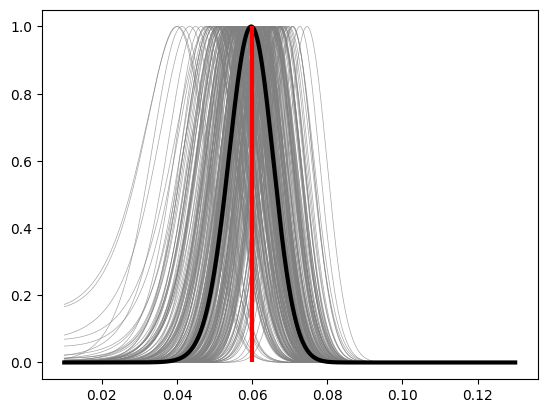

In [958]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    


#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.figure(1)
plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot 100x143')
plt.vlines(0.06,0,1,'red',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))
#plt.savefig('/Users/valentinagenesini/Documents/thesis/plots/100x143/validation_plots_no_bias.pdf')
plt.savefig('/Users/valentinagenesini/Documents/thesis/plots/100x143/validation_plots_bias.png')


# Validation 100xWL

In [963]:
fsky=fskys[1]
sims=np.empty((nsims,lmax-1-lmin+2))
#for isim in range(nsims):
    #sims[isim,:] = np.loadtxt(
        #'../spectra/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]
#covmat=np.cov(sims[:nsimscov,:].T)
#icovmat = np.linalg.inv(covmat)

In [968]:
bias=0
covmat=np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

for isim in range (nsims):
    cov[isim]=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2100xLW/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)
#i multipoli partono da 2
sims=cov[:,2,0:lmax-1]
E=(cov[:,2,0:lmax-1])
covmat=np.cov(E.T)
icovmat = np.linalg.inv(covmat)

for isim in range(nsims):
    a=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/bias_100_WL/bias_100_WL_QMLmaskSF50s2v6_clhat.dat'+str(isim).zfill(3)+'.dat', unpack=True)
    noise_sim[isim]=a[2,0:lmax-1]
    
bias= np.mean(noise_sim, axis=0) 


#se passo il parametro ells si impalla perché il fiduciale è lungo 29
#offset = (compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky))+bias
offset = (compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky))

#aggiunge l'offset calcolato a quello totale



offsets.append(offset)



In [973]:
likeSH = np.zeros((nval,ntaus))

for itau in range(ntaus):
    th=thcls[itau]+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+bias+offset)/th
        Xl = (fidcl+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.05790201259123798 0.0588402 0.00833986516168954
0.008294479742144346 0.007416724206817993 0.00833986516168954
3.9992976776669447 2.4725266357428652
0.05892661414029725 0.059500000000000004 0.007911052425646086
2.0461464916430705 1.065928020237473


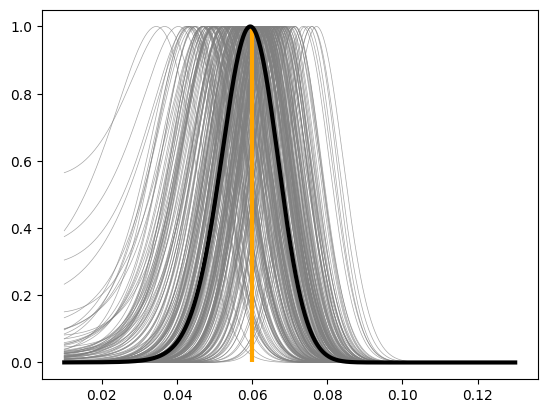

In [974]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    


#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]


plt.vlines(0.06,0,1,'orange',lw=3)
plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot_100_WL')
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation 143xWL

In [978]:
fsky=fskys[2]
sims=np.empty((nsims,lmax-1-lmin+2))
#for isim in range(nsims):
    #sims[isim,:] = np.loadtxt(
        #'../spectra/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]

In [979]:
bias=0
covmat=np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)
for isim in range (nsims):
    cov[isim]=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2143xLW/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)
sims=cov[:,2,0:lmax-1]
E=(cov[:,2,0:lmax-1])
covmat=np.cov(E.T)
icovmat = np.linalg.inv(covmat)

for isim in range(nsims):
    a=np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/bias_143_WL/bias_143_WL_QMLmaskSF50s2v6_clhat.dat'+str(isim).zfill(3)+'.dat', unpack=True)
    noise_sim[isim]=a[2,0:lmax-1]
    
bias= np.mean(noise_sim, axis=0) 


#offset = -sims.min(axis=0)*1.1
offset = compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky)
offsets.append(offset)

/Users/valentinagenesini/anaconda3/envs/python_env/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/valentinagenesini/anaconda3/envs/python_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [980]:
likeSH = np.zeros((nval,ntaus))

for itau in range(ntaus):
    th=thcls[itau]+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+bias+offset)/th
        Xl = (fidcl+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.05753594215685476 0.058537320000000004 0.00788228855061206
0.008062237730018296 0.007250374860488248 0.00788228855061206
4.832427008278749 3.1897663065545183
0.058546992777571784 0.05922 0.007475883928065059
2.8495886833255293 1.7009993430637746


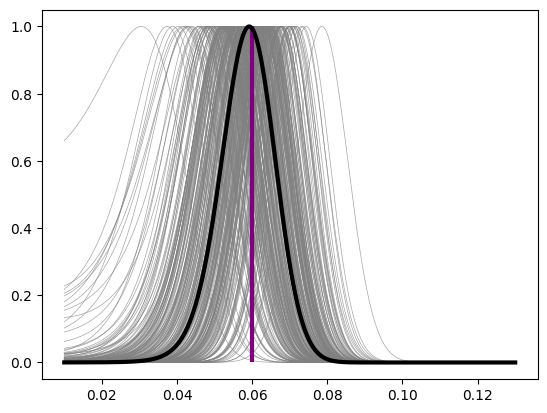

In [981]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'purple',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation WL

In [878]:
fsky=fskys[3]
sims=np.empty((nsims,lmax-1-lmin+2))
#for isim in range(nsims):
    #sims[isim,:] = np.loadtxt(
        #'../spectra/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]

In [879]:
covmat=np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)
for isim in range(nsims):
    cov[isim] = np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_' + str(isim).zfill(4) + '.dat', unpack=True)
sims=cov[:,2,0:lmax-1]
E=(cov[:,2,0:lmax-1])
covmat=np.cov(E.T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = compute_offsets(ells, sims.var(axis=0), fidcl, fsky=fsky)
offsets.append(offset)

In [880]:
likeSH = np.zeros((nval,ntaus))

for itau in range(ntaus):
    th=thcls[itau]+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th
        Xl = (fidcl+offset)*np.sign(diag - 1) * np.sqrt(2 * np.maximum(0, diag - np.log(np.abs(diag)) - 1))
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.057140975267246395 0.05751372 0.010342411286909305
0.011021196016970599 0.01089804324461965 0.010342411286909305
4.101655586351099 3.6072107278547687
0.05886290408605309 0.05904 0.009900201181680895
1.6313170551572491 1.3928126754591443


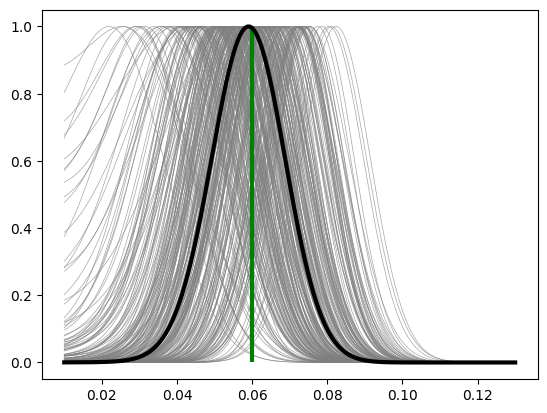

In [881]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'green',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation Full

In [882]:
sims=np.empty((nsims,4*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2100xLW/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True) [2,lmin-2:lmax-1]
    sims[isim,2*(lmax-1-lmin+2):3*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2143xLW/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,3*(lmax-1-lmin+2):4*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_' + str(isim).zfill(4) + '.dat', unpack=True) [2,lmin-2:lmax-1]

In [883]:
covmat = np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = np.concatenate((offsets[0],offsets[1],offsets[2],offsets[3]))

In [884]:
likeSH = np.zeros((nval,ntaus))

fid = np.tile(fidcl,4)
for itau in range(ntaus):
    th=np.tile(thcls[itau],4)+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th       
        Xl = (fid+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.0603585139193605 0.060483680000000005 0.004228951277509724
0.0089568231887981 0.008976932708759712 0.004228951277509724
-0.632880952406774 -0.8519226490233935
0.061309101430260006 0.06137 0.004059964488668015
-2.3109433560009807 -2.413029335846085


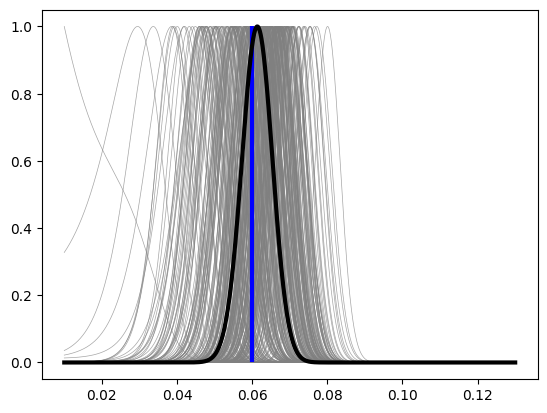

In [885]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'blue',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation 100x143 100xWL 143xWL

In [886]:
sims=np.empty((nsims,3*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2100xLW/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True) [2,lmin-2:lmax-1]
    sims[isim,2*(lmax-1-lmin+2):3*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2143xLW/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]



In [887]:
covmat = np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = np.concatenate((offsets[0],offsets[1],offsets[2]))
#offset = np.concatenate((
#    compute_offsets(ells, np.diag(covmat)[0*(lmax-1):1*(lmax-1)], fidcl, fsky=0.501),
#    compute_offsets(ells, np.diag(covmat)[1*(lmax-1):2*(lmax-1)], fidcl, fsky=0.441),
#    compute_offsets(ells, np.diag(covmat)[2*(lmax-1):3*(lmax-1)], fidcl, fsky=0.441),)
#)

In [888]:
likeSH = np.zeros((nval,ntaus))

fid = np.tile(fidcl,3)
for itau in range(ntaus):
    th=np.tile(thcls[itau],3)+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th
        Xl = (fid+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.060452741854952516 0.06067792000000001 0.004813147806245084
0.00783134655415432 0.007554219567473531 0.004813147806245084
-0.914080001337742 -1.418923061630283
0.061108051867515875 0.061200000000000004 0.004637644451103557
-2.2371425161197536 -2.5116646122792035


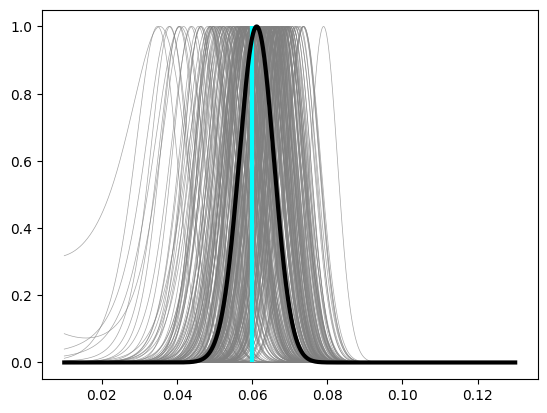

In [889]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'cyan',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation 100x143 143xWL

In [890]:
sims=np.empty((nsims,2*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2143xLW/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]


In [891]:
covmat = np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = np.concatenate((offsets[0],offsets[2]))

In [892]:
likeSH = np.zeros((nval,ntaus))

fid = np.tile(fidcl,2)
for itau in range(ntaus):
    th=np.tile(thcls[itau],2)+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th
        Xl = (fid+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.05977175163225029 0.06007672 0.0054282391681966064
0.006477328436771417 0.0062089766340033825 0.0054282391681966064
0.5571623558620729 -0.19537031332947458
0.06050288520793854 0.060680000000000005 0.005200896589784847
-1.2275606171715454 -1.7316451129306574


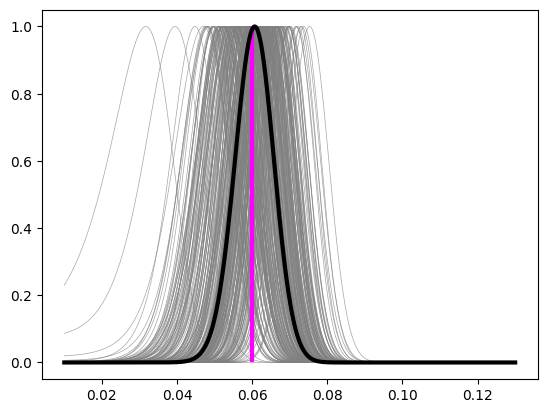

In [893]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'magenta',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation 100x143 100xWL

In [894]:
sims=np.empty((nsims,2*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2100xLW/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True) [2,lmin-2:lmax-1]



In [895]:
covmat = np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = np.concatenate((offsets[0],offsets[1]))

In [896]:
likeSH = np.zeros((nval,ntaus))

fid = np.tile(fidcl,2)
for itau in range(ntaus):
    th=np.tile(thcls[itau],2)+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th
        Xl = (fid+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.05979863408860358 0.060059560000000005 0.005454388120265152
0.007552917062361467 0.007187078864629216 0.005454388120265152
0.4215423775150314 -0.1310304652190344
0.06072942603898866 0.06082 0.00521551728095272
-1.5269912596642337 -1.803978869704425


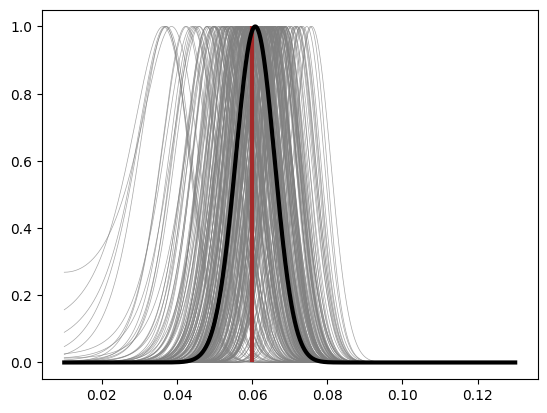

In [897]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'brown',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation 100x143 WL

In [898]:
sims=np.empty((nsims,2*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]
    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)]= np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_' + str(isim).zfill(4) + '.dat', unpack=True) [2,lmin-2:lmax-1]


In [899]:
covmat = np.cov(sims[:nsimscov,:].T)
icovmat = np.linalg.inv(covmat)

#offset = -sims.min(axis=0)*1.1
offset = np.concatenate((offsets[0],offsets[3]))

In [900]:
likeSH = np.zeros((nval,ntaus))

fid = np.tile(fidcl,2)
for itau in range(ntaus):
    th=np.tile(thcls[itau],2)+offset
    for isim in range(nval):
        diag = (sims[isim+nsimscov,:]+offset)/th
        Xl = (fid+offset)*g(diag)
        likeSH[isim,itau] = -nval/2*(1+np.dot(Xl,np.dot(icovmat,Xl))/(nval-1))

0.05928220149122996 0.05960252 0.005509177195244387
0.0074386561595506055 0.007002399620815708 0.005509177195244387
1.5257313553008751 0.8975081346594884
0.060226136322111615 0.06035 0.005210105340600555
-0.4806687015961018 -0.7902984983667727


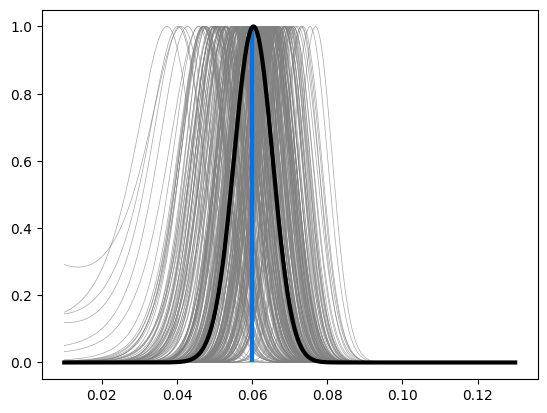

In [901]:
allmuHL = []
allbfHL = []
allsigmaHL = []

allmuSH = []
allbfSH = []
allsigmaSH = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #SH
    func = interp1d(taus[prior:],likeSH[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuSH.append(mu)
    allbfSH.append(bf)
    allsigmaSH.append(sigma)
    
plt.vlines(0.06,0,1,'#0073e6',lw=3)

#stats SH
print(np.mean(allmuSH),np.mean(allbfSH),np.mean(allsigmaSH))
print(np.std(allmuSH),np.std(allbfSH),np.mean(allsigmaSH))
print(np.sqrt(nval)*(0.06-np.mean(allmuSH))/np.std(allmuSH),
      np.sqrt(nval)*(0.06-np.mean(allbfSH))/np.std(allbfSH),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuSH),np.sqrt(nval)*(0.06-bf)/np.std(allbfSH))

# Validation Full Gaussian

In [902]:
sims=np.empty((nsims,4*(lmax-1-lmin+2)))

for isim in range(nsims):
    sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] =np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]

    sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] = np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2100xLW/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True) [2,lmin-2:lmax-1]

    sims[isim,2*(lmax-1-lmin+2):3*(lmax-1-lmin+2)] = np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/S2143xLW/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat', unpack=True)[2,lmin-2:lmax-1]

    sims[isim,3*(lmax-1-lmin+2):4*(lmax-1-lmin+2)] = np.loadtxt('/Users/valentinagenesini/Documents/thesis/QML_estimation/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_' + str(isim).zfill(4) + '.dat', unpack=True) [2,lmin-2:lmax-1]


In [903]:
covmat=np.cov(sims[:,:].T)
icovmat = np.linalg.inv(covmat)

In [904]:
likeG = np.zeros((nval,ntaus))

for itau in range(ntaus):
    th=np.tile(thcls[itau],4)
    for isim in range(nval):
        delta = sims[isim+nsimscov,:]-th
        likeG[isim,itau] = -0.5*np.dot(delta,np.dot(icovmat,delta))

0.058280529858973515 0.059705600000000005 0.005554924159666373
0.005521259979092022 0.004844166124319023 0.005554924159666373
4.92409525623245 0.9609234275428806
0.058839184670215004 0.06005 0.005245097632661683
3.3242596788240224 -0.16320031038432917


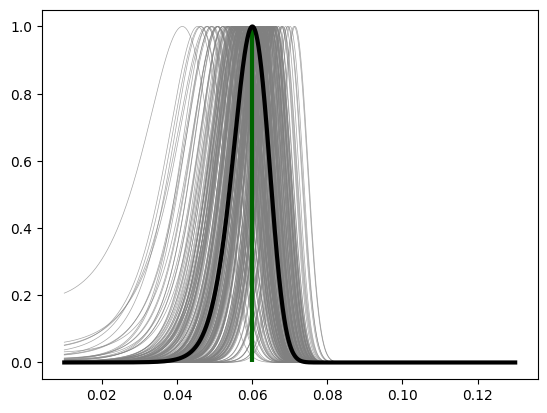

In [905]:
allmuG = []
allbfG = []
allsigmaG = []

likesum = np.zeros_like(tausover[priorover:])

for isim in range(nval):
    #G
    func = interp1d(taus[prior:],likeG[isim,prior:],kind='cubic')
    likeover = func(tausover[priorover:])
    likesum += likeover
    prob = np.exp(likeover-likeover.max())
    plt.plot(tausover[priorover:],prob,lw=0.5,alpha=0.7,color='grey')
    mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
    sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
    bf = tausover[priorover+np.argmax(prob)]
    allmuG.append(mu)
    allbfG.append(bf)
    allsigmaG.append(sigma)
    
plt.vlines(0.06,0,1,'darkgreen',lw=3)

#stats SH
print(np.mean(allmuG),np.mean(allbfG),np.mean(allsigmaG))
print(np.std(allmuG),np.std(allbfG),np.mean(allsigmaG))
print(np.sqrt(nval)*(0.06-np.mean(allmuG))/np.std(allmuG),
      np.sqrt(nval)*(0.06-np.mean(allbfG))/np.std(allbfG),
     )

likesum /= nval
prob = np.exp(likesum-likesum.max())
mu = np.sum(tausover[priorover:]*prob)/np.sum(prob)
sigma = np.sqrt((np.sum(tausover[priorover:]**2*prob)/np.sum(prob))-mu**2)
bf = tausover[priorover+np.argmax(prob)]

plt.plot(tausover[priorover:],prob,'k',lw=3)
print(mu,bf,sigma)
print(np.sqrt(nval)*(0.06-mu)/np.std(allmuG),np.sqrt(nval)*(0.06-bf)/np.std(allbfG))

# Play with the covmat

In [908]:
#sims=np.empty((nsims,4*(lmax-1-lmin+2)))

#for isim in range(nsims):
    #sims[isim,0*(lmax-1-lmin+2):1*(lmax-1-lmin+2)] = np.loadtxt(
        #'../spectra/sroll2_100x143_smcw_Tc17v2_fgcKKa353psbSF70s2v6_covffp8_QMLmaskSF50s2v6_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]
    #sims[isim,1*(lmax-1-lmin+2):2*(lmax-1-lmin+2)] = np.loadtxt(
        #'../spectra/S2100xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]
    #sims[isim,2*(lmax-1-lmin+2):3*(lmax-1-lmin+2)] = np.loadtxt(
        #'../spectra/S2143xLW_QMLmaskSF50s2v6XintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]
    #sims[isim,3*(lmax-1-lmin+2):4*(lmax-1-lmin+2)] = np.loadtxt(
        #'../spectra/LFI70GHzfgcSF60_WMAP_fgcKa55Q55V75_noise_marg_v10_QMLmaskintersectionSF50_clhat_'+str(isim).zfill(4)+'.dat',
        #usecols=(2,))[lmin-2:lmax-1]   

In [ ]:
#covmat=np.cov(sims[:nsimscov,:].T)
#sigma = np.sqrt(np.diag(covmat))
#plt.imshow(covmat/np.outer(sigma,sigma)-np.diag(np.ones_like(sigma)),origin='lower')
#plt.colorbar()

In [ ]:
#icovmat = np.linalg.inv(covmat)

In [ ]:
#plt.imshow(np.matmul(covmat,icovmat)-np.diag(np.ones_like(sigma)),origin='lower')
#plt.colorbar()

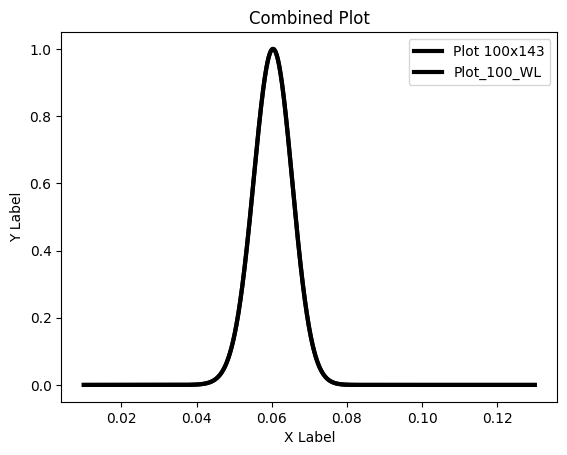

In [910]:
plt.figure(3)
plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot 100x143')
plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot_100_WL')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.title('Combined Plot')
plt.legend()

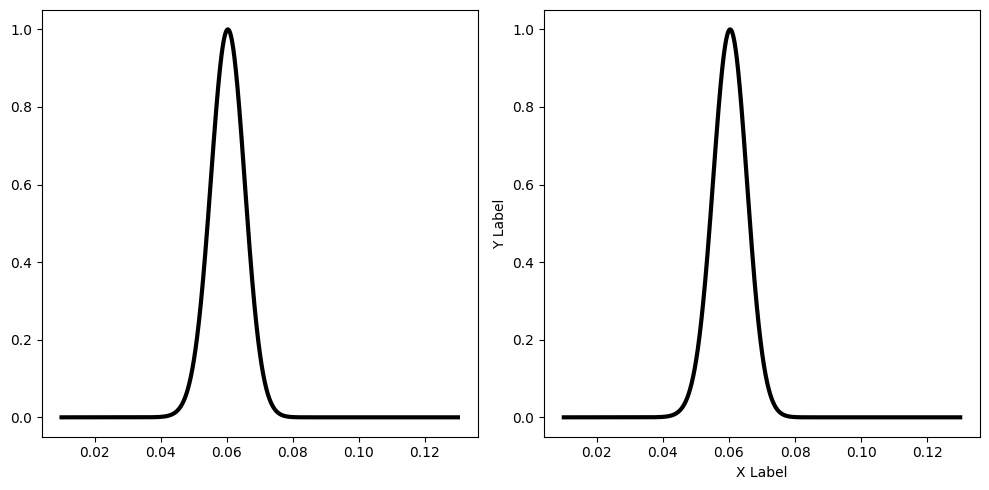

In [912]:
plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura
plt.subplot(1, 2, 1)  # Primo subplot
plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot 100x143')



plt.subplot(1, 2, 2)  # Secondo subplot

plt.plot(tausover[priorover:],prob,'k',lw=3, label='Plot_100_WL')

# Aggiungi etichette agli assi
plt.xlabel('X Label')
plt.ylabel('Y Label')

# Mostra i subplot
plt.tight_layout()  # Opzionale: migliora la disposizione dei subplot
plt.show()

NameError: name 'x2' is not defined

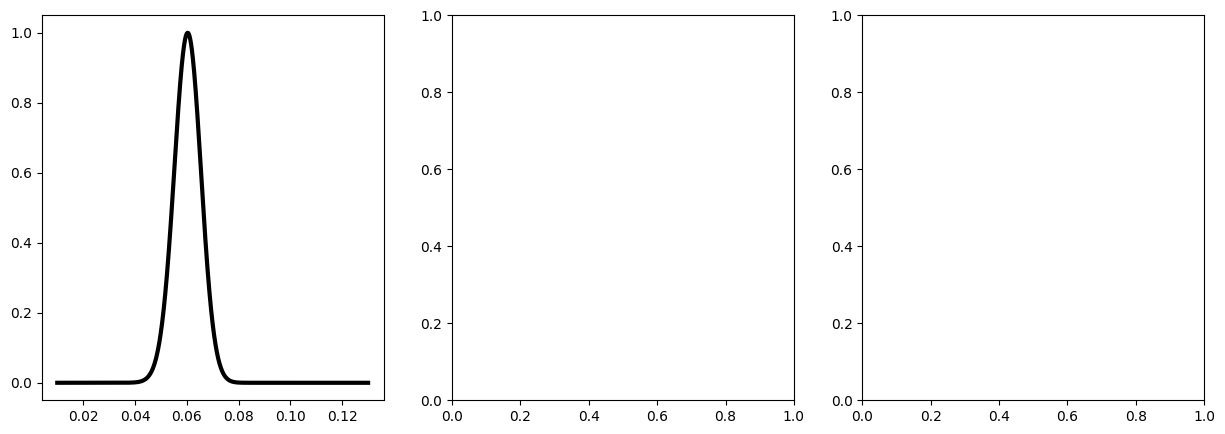

In [914]:
fig = plt.figure(figsize=(15, 5))  # Imposta la dimensione della figura

# Aggiungi i subplot alla figura
ax1 = fig.add_subplot(1, 3, 1)  # Primo subplot
ax2 = fig.add_subplot(1, 3, 2)  # Secondo subplot
ax3 = fig.add_subplot(1, 3, 3)  # Terzo subplot

# Plotta i plot nelle posizioni dei subplot
ax1.plot(tausover[priorover:],prob,'k',lw=3, label='Plot 100x143')# Plot 1
ax2.plot(tausover[priorover:],prob,'k',lw=3, label='Plot_100_WL')# Plot 2
ax3.plot(x3, y3)  # Plot 3

# Aggiungi etichette agli assi e titoli ai subplot
ax1.set_xlabel('X Label 1')
ax1.set_ylabel('Y Label 1')
ax1.set_title('Plot 1')

ax2.set_xlabel('X Label 2')
ax2.set_ylabel('Y Label 2')
ax2.set_title('Plot 2')

ax3.set_xlabel('X Label 3')
ax3.set_ylabel('Y Label 3')
ax3.set_title('Plot 3')

# Ottimizza la disposizione dei subplot
plt.tight_layout()

# Mostra i subplot
plt.show()

### 